# Draft

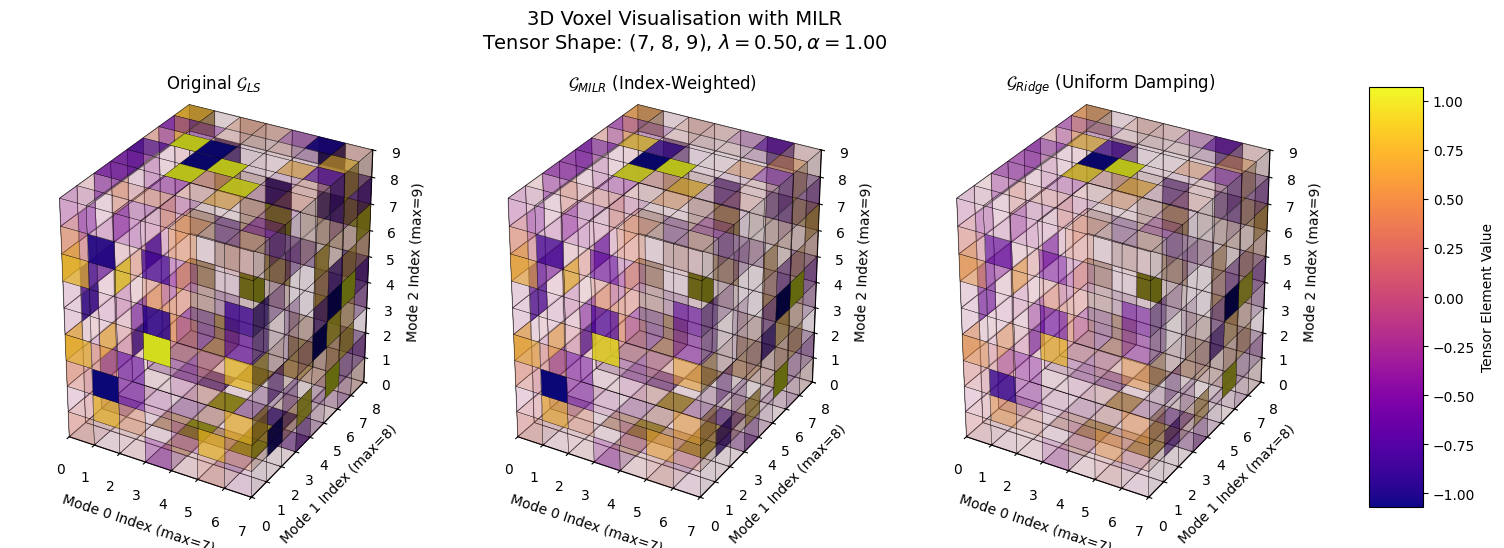

Lambda (λ): 0.5
Alpha (α): 1.0
Uniform Damping factor (1 / (1 + λ)): 0.6667
Min/Max of W_G: 0.1263 / 1.0000
Min/Max of MILR damping factors: 0.6667 / 0.9406
95th percentile of |G_LS|: 1.07
Colourbar range: -1.07 to 1.07


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm

CMAP_PALETTE = 'plasma'

# --- Parameters ---
lambda_val = 0.5
alpha_val = 1.0  
tensor_shape = (7, 8, 9)  

# G_LS will have this shape (L1, L2, L3) for plotting
# Note: For MILR, G is usually (1, L2, L3, ... LN)

background_mean = 0.0
background_std = 0.5
hotspot_scale_factor = 5

# --- 1. Create a synthetic "original" core tensor (G_LS) ---
np.random.seed(42)
G_LS = np.random.normal(loc=background_mean, scale=background_std, size=tensor_shape)

# Define hotspot locations (no change here)
hotspot_regions = [
    {'coords': (slice(1, 3), slice(1, 3), slice(1, 3)), 'value_scale': 1.0 * hotspot_scale_factor},
    {
        'coords': (
            slice(tensor_shape[0] - 2, tensor_shape[0]),
            slice(tensor_shape[1] - 3, tensor_shape[1] - 1),
            slice(tensor_shape[2] // 2 - 1, tensor_shape[2] // 2 + 1)
        ),
        'value_scale': 0.8 * hotspot_scale_factor
    },
    {
        'coords': (
            slice(tensor_shape[0] // 2 - 1, tensor_shape[0] // 2 + 1),
            slice(tensor_shape[1] // 2, tensor_shape[1] // 2 + 2),
            slice(tensor_shape[2] - 2, tensor_shape[2])
        ),
        'value_scale': -0.9 * hotspot_scale_factor
    }
]
for hs in hotspot_regions:
    s = hs['coords']
    shape_hs = tuple(sl.stop - sl.start for sl in s)
    G_LS[s] += np.random.randn(*shape_hs) * background_std * hs['value_scale']

# --- 2. Calculate the MILR weights and the damped core tensor (G_MILR) ---

# Create index grids for each mode (0-based for numpy, convert to 1-based for formula)
# These are L_j values in the formula w_... = 1/(N-1) * sum (l_j / L_j)^alpha
# For this plotting example, we have 3 modes for G directly.
# In actual HOPLS, G_LS is (1, L2, L3, ..., LN), so the sum for w is over N-1 modes.
# Here, we'll assume all 3 modes of G_LS contribute to the weight calculation.
# If tensor_shape represents (L2, L3, L4) for a G_LS that is (1, L2, L3, L4),
# then N-1 = 3. If G_LS is (1, L2, L3) then N-1 = 2.

# For this example, let's say tensor_shape is (L_mode_A, L_mode_B, L_mode_C)
# and these are the L_j values for calculating the weights.
num_weight_contributing_modes = len(tensor_shape) # N-1 in formula would be this
W_G = np.zeros_like(G_LS, dtype=float)

# Get the dimensions (total number of "columns" or elements for each mode)
L_values = tensor_shape # L_j in the formula

# Create meshgrids for 1-based indices
# For an element G[l1-1, l2-1, l3-1], its indices are l1, l2, l3
indices = [np.arange(1, L + 1) for L in L_values]
mesh_indices = np.meshgrid(*indices, indexing='ij') # l_j values

sum_normalized_indices_powered = np.zeros_like(G_LS, dtype=float)
for mode_idx in range(num_weight_contributing_modes):
    l_j = mesh_indices[mode_idx] # Indices for current mode (e.g., l1, l2, or l3)
    L_j = L_values[mode_idx]     # Total elements in current mode
    if L_j > 0: # Avoid division by zero if a dimension is 0 (shouldn't happen for shape)
        sum_normalized_indices_powered += (l_j / L_j) ** alpha_val
    # If L_j is 1, then l_j/L_j is 1. (1/1)^alpha = 1.

if num_weight_contributing_modes > 0:
    W_G = (1.0 / num_weight_contributing_modes) * sum_normalized_indices_powered
else # Should not happen if tensor_shape has dimensions
    W_G = np.zeros_like(G_LS, dtype=float)


# Element-wise damping factor tensor
damping_factors_milr = 1.0 / (1.0 + lambda_val * W_G)
G_MILR = G_LS * damping_factors_milr


# --- For comparison, let's keep your original Ridge calculation ---
damping_factor_ridge = 1.0 / (1.0 + lambda_val)
G_Ridge_comparison = G_LS * damping_factor_ridge

# --- 3. Determine improved colourbar scaling (no change) ---
abs_vals = np.abs(G_LS).ravel()
p95 = np.percentile(abs_vals, 95)
vmin_global = -p95
vmax_global = p95
divnorm = TwoSlopeNorm(vmin=vmin_global, vcenter=0.0, vmax=vmax_global)

# --- 4. Helper function for 3D Voxel plot (no change) ---
def plot_3d_tensor_voxels(ax, tensor_data, title, norm, cmap=CMAP_PALETTE):
    filled = np.ones(tensor_data.shape, dtype=bool)
    facecolours = plt.get_cmap(cmap)(norm(tensor_data))
    abs_normalised = np.abs(norm(tensor_data) - norm(0))
    alpha_vals = np.clip(abs_normalised * 2, 0.1, 1.0)
    facecolours[..., 3] = alpha_vals
    ax.voxels(filled, facecolors=facecolours, edgecolor='k', linewidth=0.2)
    ax.set_title(title)
    ax.set_xlabel(f"Mode 0 Index (max={tensor_data.shape[0]})")
    ax.set_ylabel(f"Mode 1 Index (max={tensor_data.shape[1]})")
    ax.set_zlabel(f"Mode 2 Index (max={tensor_data.shape[2]})")
    ax.set_xlim([0, tensor_data.shape[0]])
    ax.set_ylim([0, tensor_data.shape[1]])
    ax.set_zlim([0, tensor_data.shape[2]])
    ax.set_box_aspect(tensor_data.shape)

# --- 5. Visualization ---
fig = plt.figure(figsize=(18, 6)) # Adjusted for three plots
fig.suptitle(
    f"3D Voxel Visualisation with MILR\n"
    f"Tensor Shape: {tensor_shape}, $\\lambda = {lambda_val:.2f}, \\alpha = {alpha_val:.2f}$",
    fontsize=14
)

# Plot original G_LS
ax1 = fig.add_subplot(131, projection='3d')
plot_3d_tensor_voxels(ax1, G_LS, r"Original $\mathcal{G}_{LS}$", norm=divnorm, cmap=CMAP_PALETTE)

# Plot MILR G_MILR
ax2 = fig.add_subplot(132, projection='3d')
plot_3d_tensor_voxels(ax2, G_MILR, r"$\mathcal{G}_{MILR}$ (Index-Weighted)", norm=divnorm, cmap=CMAP_PALETTE)

# Plot Ridge G_Ridge for comparison
ax3 = fig.add_subplot(133, projection='3d')
plot_3d_tensor_voxels(ax3, G_Ridge_comparison, r"$\mathcal{G}_{Ridge}$ (Uniform Damping)", norm=divnorm, cmap=CMAP_PALETTE)


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(CMAP_PALETTE), norm=divnorm)
sm.set_array([])
fig.subplots_adjust(right=0.85, wspace=0.1) # Added wspace
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Tensor Element Value")

plt.show()

print(f"Lambda (λ): {lambda_val}")
print(f"Alpha (α): {alpha_val}")
print(f"Uniform Damping factor (1 / (1 + λ)): {damping_factor_ridge:.4f}")
# print(f"MILR Damping factors (W_G):\n {W_G}") # Can be large to print
# print(f"MILR Damping factors (1 / (1 + λW_G)):\n {damping_factors_milr}")
print(f"Min/Max of W_G: {W_G.min():.4f} / {W_G.max():.4f}")
print(f"Min/Max of MILR damping factors: {damping_factors_milr.min():.4f} / {damping_factors_milr.max():.4f}")
print(f"95th percentile of |G_LS|: {p95:.2f}")
print(f"Colourbar range: {vmin_global:.2f} to {vmax_global:.2f}")

# Functions to call

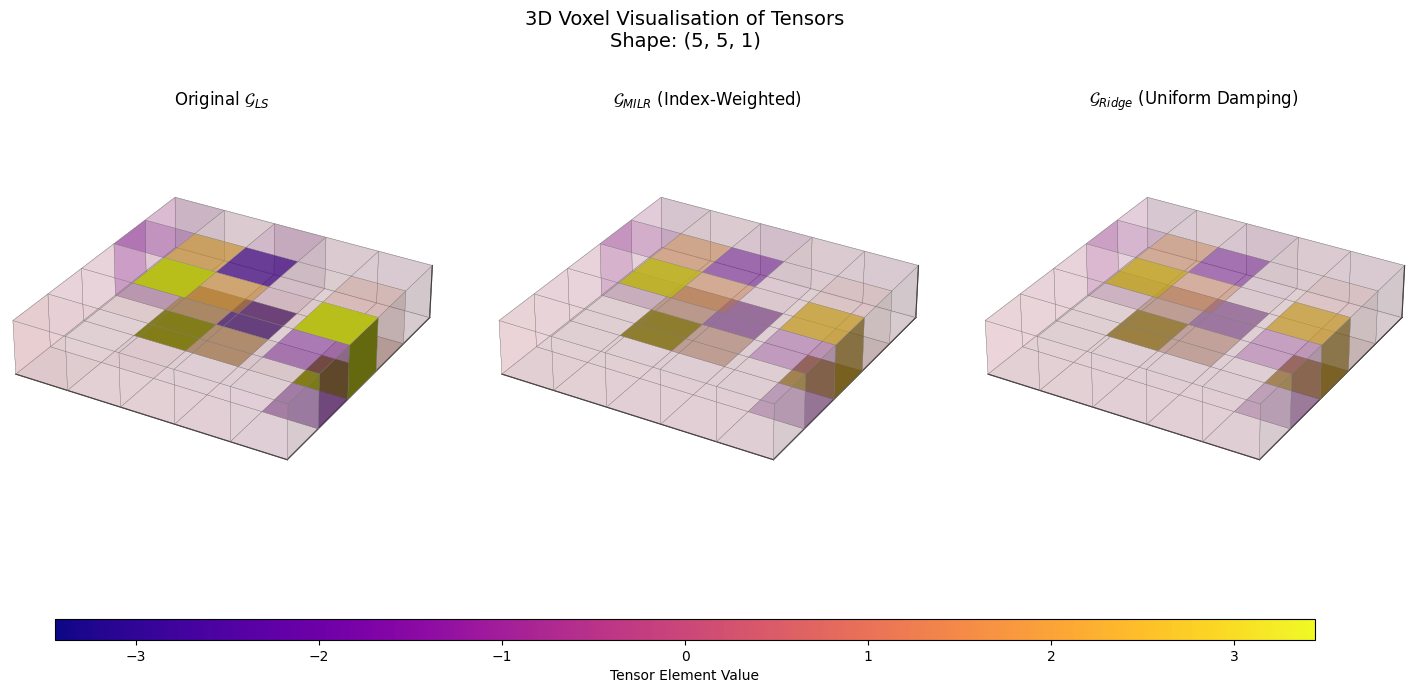

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import TwoSlopeNorm

CMAP_PALETTE = "plasma"


def generate_tensors(
    lambda_val,
    alpha_val,
    tensor_shape,
    background_mean=0.0,
    background_std=0.5,
    hotspot_scale_factor=5,
):
    """
    Generates:
      - G_LS:  the synthetic "original" 3D core tensor with background noise and hotspots,
      - G_MILR: the MILR‐damped version of G_LS,
      - G_Ridge: the uniformly‐damped Ridge version of G_LS.
    """
    np.random.seed(20)
    G_LS = np.random.normal(
        loc=background_mean, scale=background_std, size=tensor_shape
    )

    # 2. Add hotspot structure (clipping slices to valid ranges)
    hotspot_regions = [
        {
            "coords": (
                slice(1, min(3, tensor_shape[0])),
                slice(1, min(3, tensor_shape[1])),
                slice(1, min(3, tensor_shape[2])),
            ),
            "value_scale": 1.0 * hotspot_scale_factor,
        },
        {
            "coords": (
                slice(max(tensor_shape[0] - 2, 0), tensor_shape[0]),
                slice(max(tensor_shape[1] - 3, 0), max(tensor_shape[1] - 1, 0)),
                slice(
                    max(tensor_shape[2] // 2 - 1, 0),
                    min(tensor_shape[2] // 2 + 1, tensor_shape[2]),
                ),
            ),
            "value_scale": 0.8 * hotspot_scale_factor,
        },
        {
            "coords": (
                slice(
                    max(tensor_shape[0] // 2 - 1, 0),
                    min(tensor_shape[0] // 2 + 1, tensor_shape[0]),
                ),
                slice(
                    max(tensor_shape[1] // 2, 0),
                    min(tensor_shape[1] // 2 + 2, tensor_shape[1]),
                ),
                slice(max(tensor_shape[2] - 2, 0), tensor_shape[2]),
            ),
            "value_scale": -0.9 * hotspot_scale_factor,
        },
    ]
    for hs in hotspot_regions:
        s = hs["coords"]
        actual_shape = G_LS[s].shape
        if np.prod(actual_shape) == 0:
            continue
        G_LS[s] += np.random.randn(*actual_shape) * background_std * hs["value_scale"]

    # 3. Compute MILR weights W_G
    num_modes = len(tensor_shape)
    indices = [np.arange(1, L + 1) for L in tensor_shape]
    mesh_indices = np.meshgrid(*indices, indexing="ij")
    sum_normalised_indices = np.zeros_like(G_LS, dtype=float)
    for mode_idx in range(num_modes):
        l_j = mesh_indices[mode_idx]
        L_j = tensor_shape[mode_idx]
        sum_normalised_indices += (l_j / L_j) ** alpha_val
    W_G = (1.0 / num_modes) * sum_normalised_indices

    # 4. Apply MILR damping elementwise
    damping_factors_milr = 1.0 / (1.0 + lambda_val * W_G)
    G_MILR = G_LS * damping_factors_milr

    # 5. Uniform Ridge damping for comparison
    damping_factor_ridge = 1.0 / (1.0 + lambda_val)
    G_Ridge = G_LS * damping_factor_ridge

    return G_LS, G_MILR, G_Ridge, W_G, damping_factors_milr


def plot_tensors(
    G_LS,
    G_MILR,
    G_Ridge,
    orientation="vertical",
    symmetric_colouring=True,
    cmap=CMAP_PALETTE,
    tensor_labels=None,  # optional list/tuple of 3 title strings
    title_label=None,  # optional main title for the figure
):
    """
    Plots three 3D voxel subplots in either a 3×1 (vertical) or 1×3 (horizontal) layout.
    orientation: 'vertical' for 3 rows × 1 column, 'horizontal' for 1 row × 3 columns.
    """
    
    title_label = title_label or "3D Voxel Visualisation of Tensors"
    
    # prepare titles for each subplot
    default_titles = [
        r"Original $\mathcal{G}_{LS}$",
        r"$\mathcal{G}_{MILR}$ (Index‐Weighted)",
        r"$\mathcal{G}_{Ridge}$ (Uniform Damping)",
    ]
    if tensor_labels is None:
        titles_to_use = default_titles
    else:
        titles_to_use = list(tensor_labels)[:3]
        # pad with defaults if fewer than 3 provided
        titles_to_use += default_titles[len(titles_to_use) :]
    abs_vals = np.abs(G_LS).ravel()
    p95 = np.percentile(abs_vals, 95)
    if p95 == 0:
        vmin_global, vcenter_global, vmax_global = -1.0, 0.0, 1.0
    else:
        if symmetric_colouring:
            vmin_global, vcenter_global, vmax_global = -p95, 0.0, p95
        else:
            vmin_global, vcenter_global, vmax_global = 0.0, p95 / 2, p95
    divnorm = TwoSlopeNorm(vmin=vmin_global, vcenter=vcenter_global, vmax=vmax_global)

    if orientation == "horizontal":
        fig = plt.figure(figsize=(18, 7))
    else:  # 'vertical'
        fig = plt.figure(figsize=(6, 18))

    fig.suptitle(
        rf"{title_label}"+f"\nShape: {G_LS.shape}",
        fontsize=14,
        y=0.95,
    )

    def _plot_single(ax, tensor_data, title):
        filled = np.ones(tensor_data.shape, dtype=bool)
        facecolours = plt.get_cmap(cmap)(divnorm(tensor_data))
        abs_normalised = np.abs(divnorm(tensor_data) - divnorm(0))
        alpha_vals = np.clip(abs_normalised * 2, 0.1, 1.0)
        facecolours[..., 3] = alpha_vals
        ax.voxels(filled, facecolors=facecolours, edgecolor="gray", linewidth=0.2)
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlim([0, tensor_data.shape[0]])
        ax.set_ylim([0, tensor_data.shape[1]])
        ax.set_zlim([0, tensor_data.shape[2]])
        ax.set_box_aspect(tensor_data.shape)

    if orientation == "horizontal":
        ax1 = fig.add_subplot(131, projection="3d")
        _plot_single(ax1, G_LS, titles_to_use[0])
        ax2 = fig.add_subplot(132, projection="3d")
        _plot_single(ax2, G_MILR, titles_to_use[1])
        ax3 = fig.add_subplot(133, projection="3d")
        _plot_single(ax3, G_Ridge, titles_to_use[2])
        fig.subplots_adjust(top=0.90, bottom=0.10, wspace=0.15)
        cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.03])
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=divnorm),
            cax=cbar_ax,
            orientation="horizontal",
        )
    else:  # vertical
        ax1 = fig.add_subplot(311, projection="3d")
        _plot_single(ax1, G_LS, titles_to_use[0])
        ax2 = fig.add_subplot(312, projection="3d")
        _plot_single(ax2, G_MILR, titles_to_use[1])
        ax3 = fig.add_subplot(313, projection="3d")
        _plot_single(ax3, G_Ridge, titles_to_use[2])
        fig.subplots_adjust(top=0.90, bottom=0.05, hspace=0.30)
        cbar_ax = fig.add_axes([0.15, 0.02, 0.70, 0.03])
        cbar = plt.colorbar(
            plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=divnorm),
            cax=cbar_ax,
            orientation="horizontal",
        )

    cbar.set_label("Tensor Element Value")
    plt.show()


lambda_val = 0.5
alpha_val = 1.0
tensor_shape = (5, 5, 1)

G_LS, G_MILR, G_Ridge, W_G, damping_factors_milr = generate_tensors(
    lambda_val=lambda_val,
    alpha_val=alpha_val,
    tensor_shape=tensor_shape,
    background_mean=0.0,
    background_std=0.5,
    hotspot_scale_factor=5,
)

# Horizontal layout (1×3):
plot_tensors(G_LS, G_MILR, G_Ridge, orientation="horizontal")

# # Vertical layout (3×1):
# plot_tensors(G_LS, G_MILR, G_Ridge, orientation='vertical')

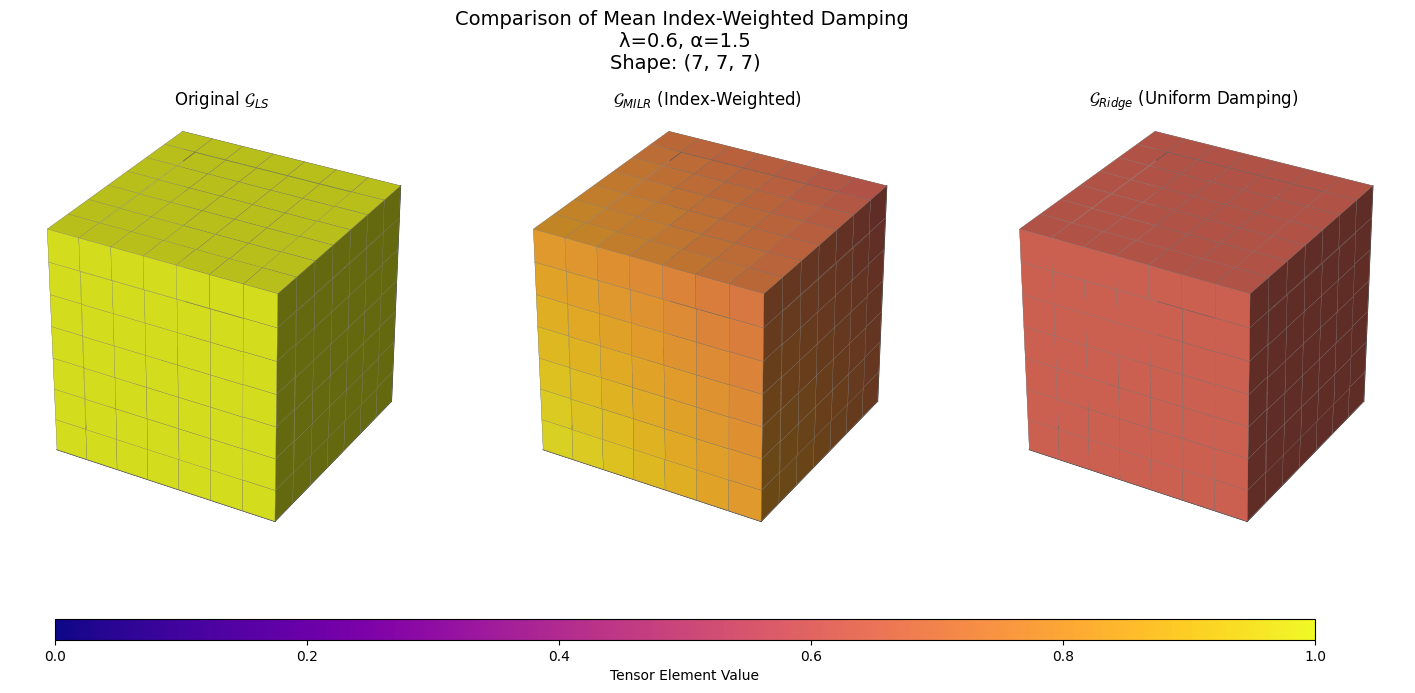

In [126]:
lambda_val = 0.6
alpha_val = 1.5
tensor_shape = (7,7,7)

G_LS, G_MILR, G_Ridge, W_G, damping_factors_milr = generate_tensors(
    lambda_val=lambda_val,
    alpha_val=alpha_val,
    tensor_shape=tensor_shape,
    background_mean=1,
    background_std=0.0,
    hotspot_scale_factor=0
)

# Horizontal layout (1×3):
plot_tensors(G_LS, G_MILR, G_Ridge, orientation='horizontal', symmetric_colouring=False, title_label=f"Comparison of Mean Index-Weighted Damping \nλ={lambda_val}, α={alpha_val}")


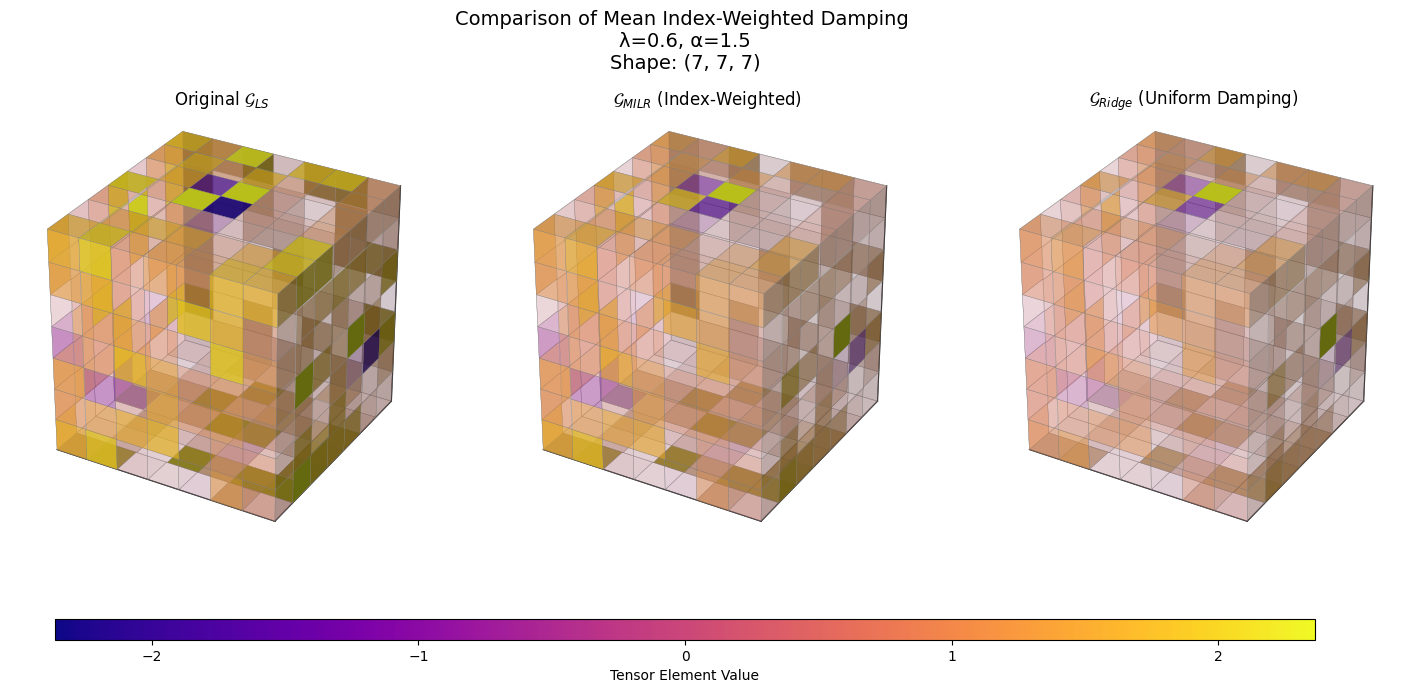

In [2]:
lambda_val = 0.6
alpha_val = 1.5
tensor_shape = (7,7,7)

G_LS, G_MILR, G_Ridge, W_G, damping_factors_milr = generate_tensors(
    lambda_val=lambda_val,
    alpha_val=alpha_val,
    tensor_shape=tensor_shape,
    background_mean=1,
    background_std=0.7,
    hotspot_scale_factor=4
)

# Horizontal layout (1×3):
plot_tensors(G_LS, G_MILR, G_Ridge, orientation='horizontal', symmetric_colouring=True,title_label=f"Comparison of Mean Index-Weighted Damping \nλ={lambda_val}, α={alpha_val}")
